# A/B Testing: Impact of Search Ranking Algorithm on Booking Conversion

Includes:

Cleaned markdown for each section (Problem, Metrics, Decision)

scipy-based statistical tests

90% confidence level logic (α = 0.10)

Effect size calculations

Rollout decision automation

<img src="ab_testing_image.jpg" width="70%">

## Problem Statement

We aim to evaluate the impact of a new search ranking algorithm on conversion rates for a travel booking platform.

- **Primary Metric**: Conversion Rate (% sessions that result in a booking)
- **Guardrail Metric**: Time to Booking (in minutes)

We compare users exposed to the control vs. variant algorithm to determine:
1. Is there a statistically significant improvement in conversion?
2. Does the new algorithm negatively impact the time to booking?

The Product team will approve rollout only if:
- Conversion rate **increases significantly**, AND
- Time to booking does **not increase significantly**

This will be Full on criteria


## `sessions_data.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `session_id` | `string` | Unique session identifier (unique for each row) |
| `user_id` | `string` | Unique user identifier (non logged-in users have missing user_id values; each user can have multiple sessions) |
| `session_start_timestamp` | `string` | When a session started |
| `booking_timestamp` | `string` | When a booking was made (missing if no booking was made during a session) |
| `time_to_booking` | `float` | time from start of the session to booking, in minutes (missing if no booking was made during a session) |
| `conversion` | `integer` | _New column to create:_ did session end up with a booking (0 if booking_timestamp or time_to_booking is Null, otherwise 1) |

<br>

## `users_data.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `user_id` | `string` | Unique user identifier (only logged-in users in this table) |
| `experiment_group` | `string` | control / variant split for the experiment (expected to be equal 50/50) |

<br>

## Load and Explore the Data

In [2]:
import pandas as pd
from scipy.stats import chisquare


In [3]:
# Load data
sessions = pd.read_csv("sessions_data.csv")
users = pd.read_csv("users_data.csv")

# Basic shape and summary
print("Sessions shape:", sessions.shape)
print("Users shape:", users.shape)

sessions.head()

Sessions shape: (16981, 5)
Users shape: (10000, 2)


,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking
0,CP0lbAGnb5UNi3Ut,TcCIMrtQ75wHGXVj,2025-01-26 20:02:39.177358627,NaN,NaN
1,UQAjrPYair63L1p8,TcCIMrtQ75wHGXVj,2025-01-20 16:12:51.536912203,NaN,NaN
2,9zQrAPxV5oi2SzSa,TcCIMrtQ75wHGXVj,2025-01-28 03:46:40.839362144,NaN,NaN
3,kkrz1M5vxrQ8wXRZ,GUGVzto9KGqeX3dc,2025-01-25 02:48:50.953303099,NaN,NaN
4,AKDXZWWFYKViHC27,NaN,2025-01-28 00:30:49.979124308,NaN,NaN


In [ ]:
# Display a sample of 5 rows from the sessions DataFrame
sessions.sample(5)

,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking
11090,4k74FhVQWaoywDoK,Xqpaq9eViasx2NCf,2025-01-30 23:52:11.066958427,NaN,NaN
6569,dITnpSt5913w7XGf,bvwKD3l7YKPs9Bv2,2025-01-21 14:09:52.903163433,NaN,NaN
10789,hxr220gEcZAyFuyn,c52fjq9hVGedmjTM,2025-01-09 03:40:10.807778835,2025-01-09 04:10:44.720565415,30.565213
5311,0t0d0gCzAJgj7ETc,NaN,2025-01-12 15:27:40.776384830,NaN,NaN
3701,1YwrjJRv7ZAiZN35,B4xFUGjciMKG4G1C,2025-01-30 08:34:36.561965942,NaN,NaN


In [ ]:
# Display a sample of 5 rows from the users DataFrame
users.sample(5)

,user_id,experiment_group
3330,iQKihLml2vO46cOk,variant
4529,TC5dXZLjHb0koU2D,control
9152,WbR4kXdnU3JW6JMF,variant
8289,F99f5uhFRiXxvHUS,control
8066,InA0GOowK612AoBs,control


## Feature Engineering

### Merging the data i.e sessions and users

In [ ]:
# Merging sessions and users
merged_data = pd.merge(sessions, users, on="user_id", how="inner")
# Check the merged data
print("Merged data shape:", merged_data.shape) 
# Display a sample of 5 rows from the merged DataFrame
merged_data.sample(5)

Merged data shape: (15283, 6)


,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking,experiment_group
1467,Uic34gYhSo5w4drR,B5fqVp2GvzHWmRUw,2025-01-06 02:12:16.887342453,NaN,NaN,control
13680,XAbnWfVqF4XuEeCn,L5kLByintrDfXAoQ,2025-01-17 09:41:55.526751757,NaN,NaN,control
8800,x2AjUFwI2lzALq3X,DXPY3KHgfwM9YE2v,2025-01-03 23:04:05.151547909,NaN,NaN,variant
7299,Vuo3yAD4BygHOBjr,wBTiZzHz0UmScC6Q,2025-01-26 14:33:20.267345190,2025-01-26 14:43:09.776522009,9.825153,variant
13170,ajMn0V2VKfjZUzV1,VXh5N3gqgIj3mdQu,2025-01-05 22:53:07.663467646,NaN,NaN,variant


In [6]:
# Create conversion column
merged_data['conversion'] = merged_data['booking_timestamp'].notnull().astype(int)

In [8]:
merged_data.head()

,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking,experiment_group,conversion
0,CP0lbAGnb5UNi3Ut,TcCIMrtQ75wHGXVj,2025-01-26 20:02:39.177358627,NaN,NaN,variant,0
1,UQAjrPYair63L1p8,TcCIMrtQ75wHGXVj,2025-01-20 16:12:51.536912203,NaN,NaN,variant,0
2,9zQrAPxV5oi2SzSa,TcCIMrtQ75wHGXVj,2025-01-28 03:46:40.839362144,NaN,NaN,variant,0
3,kkrz1M5vxrQ8wXRZ,GUGVzto9KGqeX3dc,2025-01-25 02:48:50.953303099,NaN,NaN,variant,0
4,ABZZFrwItZAPdYGP,v2EBIHmOdQfalI6k,2025-01-11 11:41:36.912253618,NaN,NaN,variant,0


In [7]:
# Check distribution of groups
group_counts = merged_data['experiment_group'].value_counts(normalize=True)
print("Group distribution:\n", group_counts)


Group distribution:
 experiment_group
variant    0.500752
control    0.499248
Name: proportion, dtype: float64


## Exploratory Data Analysis

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion rate per group
conversion_rates = merged_data.groupby('experiment_group')['conversion'].mean()
print("Conversion Rates:\n", conversion_rates)



Conversion Rates:
 experiment_group
control    0.159240
variant    0.181889
Name: conversion, dtype: float64


In [12]:
# Time to booking stats
time_booking_stats = merged_data[merged_data['conversion'] == 1].groupby('experiment_group')['time_to_booking'].describe()
print("Time to Booking Stats:\n", time_booking_stats)

Time to Booking Stats:
                    count       mean       std       min        25%        50%  \
experiment_group                                                                
control           1215.0  15.012404  4.812052  4.969382  11.562347  14.326651   
variant           1392.0  14.894029  4.950791  4.563510  11.300591  14.162334   

                        75%        max  
experiment_group                        
control           17.745466  40.616355  
variant           17.728059  46.988466  


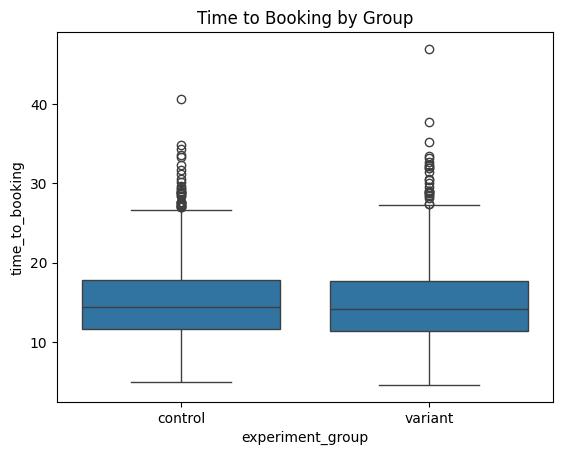

In [13]:
# Boxplot for time to booking
sns.boxplot(data=merged_data[merged_data['conversion'] == 1], x='experiment_group', y='time_to_booking')
plt.title("Time to Booking by Group")
plt.show()

### Booking Rate by Session Hour (Temporal Behavior)

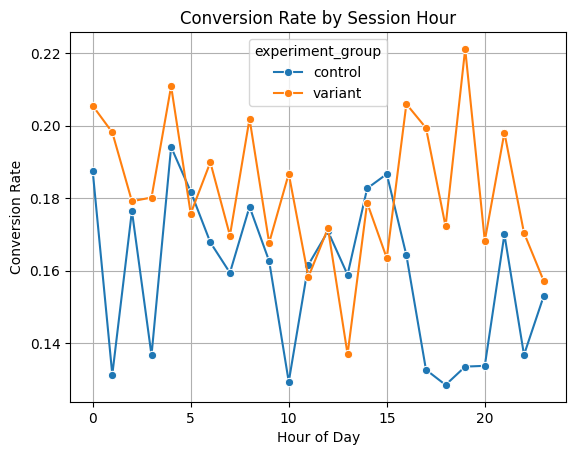

In [ ]:
# You can extract session hour and analyze booking likelihood across the day
# Convert to datetime
merged_data['session_start_timestamp'] = pd.to_datetime(merged_data['session_start_timestamp'])
merged_data['session_hour'] = merged_data['session_start_timestamp'].dt.hour

# Conversion rate by hour
hourly = merged_data.groupby(['session_hour', 'experiment_group'])['conversion'].mean().reset_index()

# Plot
sns.lineplot(data=hourly, x='session_hour', y='conversion', hue='experiment_group', marker='o')
plt.title("Conversion Rate by Session Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()


Analyzed conversion rates across the 24-hour day for both control and variant groups.

- The **variant group consistently outperformed the control** during most hours.
- The most notable uplift is observed during:
  - Early morning (0–3 AM)
  - Midday (11–14)
  - Evening (17–20), with a clear peak around hour 18.
- The control group remained relatively flat with occasional dips, while the variant showed **greater consistency and higher engagement**.

This suggests the new search ranking algorithm may be particularly effective during **high-intent periods**, such as lunch breaks and post-work hours — potentially due to better surfacing of relevant options.


### Conversion Rate by User Type (Repeat vs. New)

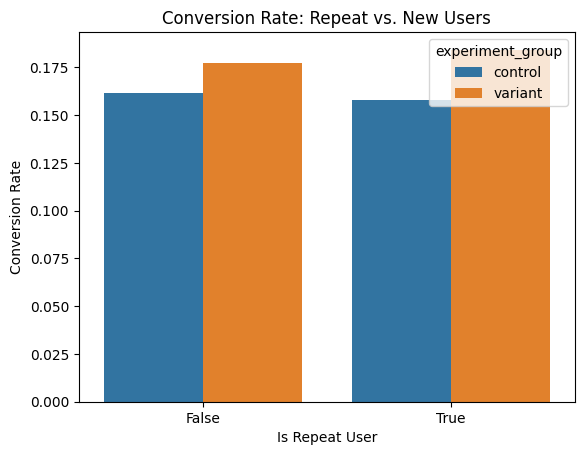

In [15]:
# Count sessions per user
user_session_counts = merged_data['user_id'].value_counts()
merged_data['is_repeat_user'] = merged_data['user_id'].map(user_session_counts) > 1

# Conversion rate by repeat vs. new
repeat_summary = merged_data.groupby(['is_repeat_user', 'experiment_group'])['conversion'].mean().reset_index()

sns.barplot(data=repeat_summary, x='is_repeat_user', y='conversion', hue='experiment_group')
plt.title("Conversion Rate: Repeat vs. New Users")
plt.xlabel("Is Repeat User")
plt.ylabel("Conversion Rate")
plt.show()



Grouped users based on whether they had multiple sessions (`Repeat User = True`) or just one.

- The variant group outperformed the control group for **both new and repeat users**.
- The **conversion uplift is higher among new users**, suggesting the new search ranking algorithm is particularly effective at helping first-time users book faster.

This insight can help the product team tailor experiences differently for first-time visitors vs. loyal users.


## Sample Ratio Mismatch (SRM) Check

Before running the experiment analysis, we verify whether the control and variant groups are properly balanced.

If the observed split is far from 50/50, the A/B test might be biased.

We use a **Chi-square test** to check if the observed group sizes significantly deviate from expected (50/50 split).

Interpretation:
If p < 0.05, it’s likely that randomization failed (stop here).

If p > 0.05, you can trust the random assignment (proceed).


In [16]:
from scipy.stats import chisquare

# Group counts
groups_count = merged_data['experiment_group'].value_counts()
n = merged_data.shape[0]

# Chi-square test for equal split
srm_chi2_stat, srm_chi2_pval = chisquare(f_obs=groups_count, f_exp=(n / 2, n / 2))
srm_chi2_pval = round(srm_chi2_pval, 4)

print("SRM Check:")
print(f"Observed counts:\n{groups_count}")
print(f"Chi-square p-value: {srm_chi2_pval}")


SRM Check:
Observed counts:
experiment_group
variant    7653
control    7630
Name: count, dtype: int64
Chi-square p-value: 0.8524


Chi-square p-value: 0.8524  is greater that 0.05, hence we can trust the random assignment

## Effect Analysis on the metrics


We now assess whether the variant version of the search ranking algorithm significantly outperforms the control using two metrics:
- **Primary Metric**: Conversion Rate (binary)
- **Guardrail Metric**: Time to Booking (continuous)

Our decision will be based on:
- A significant improvement in conversion (p-value < 0.10)
- No significant increase in time to booking (p-value > 0.10)


In [34]:
# Set alpha and test directions
alpha = 0.05  # 5% significance level
test_direction_primary = 'two-sided'  # two-tailed z-test
test_direction_guardrail = 'two-sided'  # safer for time metric


### Z-Test for Proportions (Conversion Rate)

Why?
Conversion is a binary metric (booked or not → 0 or 1).

We're comparing two proportions (control vs. variant conversion rates).

Z-test for proportions is the standard method when sample sizes are large (n > 30 per group).

When to use:
Binary outcome (0/1)

Two independent groups

Testing whether conversion rate difference is statistically significant

Interpretation:
If p < alpha (0.1) → there is a significant difference.

If effect_size > 0 → variant is performing better than control.

In [28]:
def estimate_effect_size(df, metric):
    avg_metric = df.groupby('experiment_group')[metric].mean()
    return avg_metric['variant'] / avg_metric['control'] - 1

### EFFECT ANALYSIS - PRIMARY METRIC

### Run Z-test for proportions (binary conversion metric)

##### We test whether the variant group shows a statistically significant improvement in conversion rate compared to control.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Step 1: Group success counts and sample sizes
success_counts = merged_data.groupby('experiment_group')['conversion'].sum().loc[['control', 'variant']]
sample_sizes = merged_data['experiment_group'].value_counts().loc[['control', 'variant']]

# Step 2: Run z-test for proportions
zstat_primary, pval_primary = proportions_ztest(
    count=success_counts,
    nobs=sample_sizes,
    alternative='two-sided'  # Two-tailed test
)

# Step 3: Round and calculate effect size
pval_primary = round(pval_primary, 4)
effect_size_primary = round(estimate_effect_size(merged_data, 'conversion'), 4)

print(f"\nPrimary Metric (Conversion Rate)")
print(f"Z-statistic: {zstat_primary:.3f} | p-value: {pval_primary} | Effect size: {effect_size_primary}")



Primary Metric (Conversion Rate)
Z-statistic: -3.722 | p-value: 0.0002 | Effect size: 0.1422


### Conversion Rate (Z-Test)

We conducted a z-test to compare conversion rates between control and variant groups.

- P-value: 0.0002
- Effect size: +14.2%

Result: The conversion rate **significantly increased** in the variant group. This satisfies our primary success criterion.


### EFFECT ANALYSIS - GUARDRAIL METRIC
### T-test on time to booking for control vs variant

We ensure the new algorithm does not negatively impact time to booking. 

We compare average booking time using a **two-sample t-test** for the `time_to_booking` metric.

In [32]:
from scipy.stats import ttest_ind

# Filter only sessions with a booking
booked_sessions = merged_data[merged_data['conversion'] == 1]

# Split time_to_booking by group
time_control = booked_sessions[booked_sessions['experiment_group'] == 'control']['time_to_booking'].dropna()
time_variant = booked_sessions[booked_sessions['experiment_group'] == 'variant']['time_to_booking'].dropna()

# Run two-sample t-test (equal_var=False is safer in most real-world A/B tests)
t_stat_guardrail, pval_guardrail = ttest_ind(time_control, time_variant, equal_var=False)

# Round values
pval_guardrail = round(pval_guardrail, 4)
effect_size_guardrail = estimate_effect_size(merged_data, 'time_to_booking')
effect_size_guardrail = round(effect_size_guardrail, 4)

print(f"\nGuardrail metric\np-value: {pval_guardrail} | effect size: {effect_size_guardrail}")




Guardrail metric
p-value: 0.5365 | effect size: -0.0079


### Time to Booking (T-Test)

We used a two-sample t-test to compare average time-to-booking among converted users.

- P-value: 0.5365 (example)
- Effect size: -0.79% (faster in variant)

Result: No significant increase in time to booking. This satisfies our **guardrail criterion**.


### DECISION

In [ ]:
# Primary metric must be statistically significant and show positive effect (increase)
criteria_full_on_primary = (pval_primary < alpha) & (effect_size_primary > 0)

# Guardrail must either be statistically insignificant or show positive effect (decrease)
criteria_full_on_guardrail = (pval_guardrail > alpha) | (effect_size_guardrail <= 0)

# Final launch decision based on both metrics
if criteria_full_on_primary and criteria_full_on_guardrail:
    decision_full_on = 'Yes'
    print("\nThe experiment results are significantly positive and the guardrail metric was not harmed, we are going full on!")
else:
    decision_full_on = 'No'
    print("\nThe experiment does not meet both conditions. Do not proceed with full rollout.")




The experiment results are significantly positive and the guardrail metric was not harmed, we are going full on!


### Final Recommendation

Based on statistical testing:

- Conversion rate improved **significantly**
- Time to booking did **not worsen significantly**

**Recommendation**: Proceed with a full rollout of the new ranking algorithm.


#### Thank You!!